### FilterNet
A neural network for filtering out gaussian noise from an image introduced by aggressive accelerations on the vehicle carrying the camera.

In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
from skimage import io, transform
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from typing import List, Dict, Tuple
from tqdm import tqdm

### Dataset Class and Dataloader

In [2]:
# Set device to cuda
device = torch.device('cuda:0')

# Create dataset class
class VideoDataset(Dataset):
    def __init__(self, path_to_data, augmented=False, num_vids=7, seq_length=5, img_size=256):
        """
        Go through each video folder and build a map from
        index i in range [0, N], where N is the total number
        of frames in all the videos, to a tuple (j, k), where
        j is the video number and k the frame index in that
        video. For reference, the videos are stored in the
        dataset as:

        data:
        - test1:
          - inputs:
            - bd_poses.csv
            - bd_twists.csv
            - frame0000.png
            - frame0001.png
            - ...
          - targets:
            - frame0000.png
            - frame0001.png
            - ...
        - test2:
            - ...
        - ...
        """
        self.img_size = img_size
        self.seq_length = seq_length
        self.augmented = augmented
        self.num_vids = num_vids
        self.path_to_data = path_to_data
        self.idx_map: List[Tuple[int, int]] = []
        self.poses: Dict[int, np.ndarray] = {}
        self.twists: Dict[int, np.ndarray] = {}
        for i in tqdm(range(1, self.num_vids + 1)):
            # Define path to pose
            pose_path = os.path.join(path_to_data, f'test{i}/inputs/bd_poses.csv')
            twist_path = os.path.join(path_to_data, f'test{i}/inputs/bd_twists.csv')

            # Check that files were opened properly
            if not os.path.isfile(pose_path):
                raise FileNotFoundError(f"Missing pose file: {pose_path}")
            if not os.path.isfile(twist_path):
                raise FileNotFoundError(f"Missing twist file: {twist_path}")

            # Get poses
            self.poses[i] = pd.read_csv(pose_path).to_numpy()
            self.twists[i] = pd.read_csv(twist_path).to_numpy()

            # Get number of sequences in this video: num_frames - (seq_length - 1)
            num_sequences = (self.poses[i].shape[0] - 1) - (self.seq_length - 1)

            # Update index map
            video_num = [i] * num_sequences
            frame_idx = list(range(0, num_sequences))
            self.idx_map.extend(list(zip(video_num, frame_idx)))

        self.total_num_sequences = len(self.idx_map)

    def __len__(self):
        """
        Return length of dataset as computed in __init__() function.
        """
        return self.total_num_sequences

    def __getitem__(self, idx):
        """
        Use map built in __init__() to retrieve the image,
        pose, and twist directly from the dataset.
        This avoids loading the entire dataset which
        overwhelms RAM.
        """
        assert idx < self.total_num_sequences
        if torch.is_tensor(idx):
            idx = idx.tolist()

        seq_start = True
        for i in range(self.seq_length):
            # Define path to data
            test_idx, frame_idx = self.idx_map[idx]
            frame_idx += i
            padded_frame_idx = self.to_zero_pad_idx(frame_idx)
            input_img_path = os.path.join(self.path_to_data,
                                    f'test{test_idx}/inputs/frame{padded_frame_idx}.png')
            output_img_path = os.path.join(self.path_to_data,
                                    f'test{test_idx}/targets/frame{padded_frame_idx}.png')

            # Debug: 
            # print(f'\ntest idx, frame idx: {test_idx, frame_idx}')

            # Load and process data
            input_frame = io.imread(input_img_path)
            output_frame = io.imread(output_img_path)
            input_frame = torch.from_numpy(self.to_grayscale(input_frame)).float()
            output_frame = torch.from_numpy(self.to_grayscale(output_frame)).float()
            pose = self.poses[test_idx][frame_idx]
            pose = torch.from_numpy(self.pose_vector_from_matrix(pose).reshape(-1, 1)).float()
            twist = torch.from_numpy(self.twists[test_idx][frame_idx].reshape(-1, 1)).float()
            state = torch.cat((pose, twist), dim=0).view(-1)

            # Resize frames
            h, w = self.img_size, self.img_size
            resize_frame = transforms.Resize((h, w))
            output_frame = resize_frame(output_frame.unsqueeze(0))
            input_frame = resize_frame(input_frame.unsqueeze(0))

            if not self.augmented:
                # Initialize sequence
                if seq_start:
                    in_frame_seq = torch.zeros_like(input_frame).view(1, 1, h, w).repeat((self.seq_length, 1, 1, 1))
                    out_frame_seq = torch.zeros_like(output_frame).view(1, 1, h, w).repeat((self.seq_length, 1, 1, 1))
                    state_seq = torch.zeros_like(state).unsqueeze(0).repeat((self.seq_length, 1))
                    seq_start = False

                # Update sequence
                in_frame_seq[i] = input_frame.view(1, h, w)
                out_frame_seq[i] = output_frame.view(1, h, w)
                state_seq[i] = state

            # If we want a broadcasted frame, pose, twist tensor of shape (B, T, 1, H, W, 14)
            else:
                expanded_frame = input_frame.view(1, h, w, 1)
                expanded_state = state.view(1, 1, 1, -1).repeat(1, h, w, 1)
                augmented_frame = torch.cat((expanded_frame, expanded_state), dim=-1)

                # Initialize augmented sequence
                if seq_start:
                    aug_seq_in = torch.zeros_like(augmented_frame).unsqueeze(0).repeat((self.seq_length, 1, 1, 1, 1))
                    aug_seq_out = torch.zeros_like(output_frame).unsqueeze(0).repeat((self.seq_length, 1, 1, 1))
                    seq_start = False

                # Update augmented sequence
                aug_seq_in[i] = augmented_frame
                aug_seq_out[i] = output_frame

        return {'input': (in_frame_seq, state_seq), 'target': out_frame_seq} if not self.augmented else {'input': aug_seq_in, 'target': aug_seq_out}

    def to_zero_pad_idx(self, idx):
        """
        Convert frame index from regular index to zero-padded index.
        e.g. 1 -> 00001, 12 -> 00012
        """
        return f'{idx:05d}'

    def pose_vector_from_matrix(self, pose):
        """
        Convert 4x4 pose matrix (as a flattenned length 16 vector) into a position and quaternion length 7 vector.
        """
        pose = pose.reshape(4, 4)
        position = pose[:3, 3].reshape(3, 1)
        orientation = pose[:3, :3]

        quat = R.from_matrix(orientation).as_quat().reshape(-1, 1)
        norm_quat = quat / np.linalg.norm(quat)

        return np.vstack((position, norm_quat)).reshape(-1)

    def to_grayscale(self, image):
        """
        Convert PNG image to grayscale mask
        """
        #TODO: Try float16 type
        return (image[..., 0] > 127).astype(np.float32)


### Submodules

Here are the Encoders, Decoder, and LSTM

In [3]:
# Write classes for compression networks

#TODO: Try a conv3d encoder. conv3d layers encode temporal information. (Alternative to LSTM). An alternative to the current pipeline would
# be to use the augmented data tensor (without compressing it) and a conv3d layer to process the (T, B, 1, H, W, 14) input. Which would need to be
#reshaped to (B, 1, T, H, W, 14). I wouldn't know what to do with the state dimension. Treat them as channels (image, pose, twist)? Flatten them with the sequence dim?

class ImgEncoder(nn.Module):
    def __init__(self, in_channel=1, hidden_channel=16, out_channel=32, h_in=256, out_dim=1024):
        """
        Define convolutional neural network architecture for compressing a 256 x 256 image into a 1024 embedding vector.
        Assumes image is square.
        """
        super().__init__()

        # Compute image shape after convolution
        stride = 2
        padding_one, padding_two = 7, 1
        num_ker_one, num_ker_two = 16, 4
        h_out = (h_in + 2 * padding_one - num_ker_one) // stride + 1
        h_out = (h_out + 2 * padding_two - num_ker_two) // stride + 1

        # Define CNN
        linear_in_dim = out_channel * h_out ** 2
        linear_out_dim = out_dim
        self.conv_stack = nn.Sequential(
                            nn.Conv2d(in_channel, hidden_channel, num_ker_one, stride=stride, padding=padding_one), # h_in, w_in = (256, 256); h_out, w_out = (128, 128)
                            nn.ReLU(),
                            nn.Conv2d(hidden_channel, out_channel, num_ker_two, stride=stride, padding=padding_two), # h_in, w_in = (128, 128); h_out, w_out = (64, 64)
                            nn.ReLU(),
                            nn.Flatten(start_dim=1, end_dim=-1), # Flattens (c_out, h_out, w_out) = (32, 64, 64) into 131072
                            nn.Linear(linear_in_dim, linear_out_dim) # Encodes the 131072 length flattened convolved image into a 1024 length embedding vector
        )

    def forward(self, x):
        """
        Define neural network forward pass
        Input has shape (T, B, 1, H, W)
        """
        return self.conv_stack(x[-1])

class ImgSeqEncoder(nn.Module):
    def __init__(self, in_channel=1, hidden_channel=16, out_channel=32, h_in=256, out_dim=1024):
        """
        Define convolutional neural network architecture for compressing a SEQUENCE of 256 x 256 images into a 1024 embedding vector.
        Assumes image is square.
        """
        super().__init__()

        # Compute image shape after convolution
        stride = 2
        padding_one, padding_two = 7, 1
        num_ker_one, num_ker_two = 16, 4
        h_out = (h_in + 2 * padding_one - num_ker_one) // stride + 1
        h_out = (h_out + 2 * padding_two - num_ker_two) // stride + 1

        # Define CNN
        linear_in_dim = out_channel * h_out ** 2
        linear_out_dim = out_dim
        self.conv_stack = nn.Sequential(
                            nn.Conv2d(in_channel, hidden_channel, num_ker_one, stride=stride, padding=padding_one), # h_in, w_in = (256, 256); h_out, w_out = (128, 128)
                            nn.ReLU(),
                            nn.Conv2d(hidden_channel, out_channel, num_ker_two, stride=stride, padding=padding_two), # h_in, w_in = (128, 128); h_out, w_out = (64, 64)
                            nn.ReLU(),
                            nn.Flatten(start_dim=1, end_dim=-1), # Flattens (c_out, h_out, w_out) = (32, 64, 64) into 131072
                            nn.Linear(linear_in_dim, linear_out_dim) # Encodes the 131072 length flattened convolved image into a 1024 length embedding vector
        )

    def forward(self, x):
        """
        Define neural network forward pass
        Input has shape (T, B, 1, H, W)
        """
        seq_len, batch_size, _, h, w = x.shape
        x = x.reshape(seq_len * batch_size, 1, h, w)
        return self.conv_stack(x).reshape(seq_len, batch_size, -1)
    
class Conv3DImgSeqEncoder(nn.Module):
    def __init__(self, in_channel=1, hidden_channel=16, out_channel=32, h_in=256, out_dim=4096):
        super().__init__()

        # Image height after two conv layers with kernel size 3 and stride 2
        h_out = h_in // 8  # Assuming 2x2 stride twice
        
        self.conv_stack = nn.Sequential(
            nn.Conv3d(in_channels=in_channel, out_channels=hidden_channel,
                      kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3)),  # (B, C=1, T, H=256, W=256) --> (B, 16, T, 128, 128) 
            nn.ReLU(),

            nn.Conv3d(in_channels=hidden_channel, out_channels=out_channel,
                      kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1)), # (B, 16, T, 128, 128) --> (B, 32, T, 64, 64)
            nn.ReLU(), 
            
            nn.Conv3d(in_channels=out_channel, out_channels=out_channel, 
                      kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1)), # (B, 32, T, 64, 64) --> (B, 32, T, 32, 32) 
            nn.ReLU(), 
        )

        self.linear = nn.Linear(out_channel * h_out * h_out, out_dim)

    def forward(self, x):
        """
        x: (B, T, 1, H, W)
        return: (B, T, D_emb)
        """
        T, B, C, H, W = x.shape
        x = x.permute(1, 2, 0, 3, 4)  # -> (B, C=1, T, H, W)
        x = self.conv_stack(x)        # -> (B, C_out, T, H', W')
        B, C_out, T, H_out, W_out = x.shape
        x = x.permute(2, 0, 1, 3, 4)  # -> (T, B, C_out, H_out, W_out)
        x = x.reshape(T, B, -1)       # -> (T, B, C_out * H_out * W_out)
        x = self.linear(x)            # -> (T, B, D_emb)
        return x

class StateEncoder(nn.Module):
    def __init__(self, in_dim=13, out_dim=128):
        """
        Define linear layer to generate a length 128 embedding vector from length 13 pose and twist vector.
        """
        super().__init__()
        self.linear_layer = nn.Linear(in_dim, out_dim)

    def forward(self, x):
        """
        Define nueral network forward pass
        Input has shape (T, B, D) need (B, D) 
        """
        return self.linear_layer(x[-1])
    
class StateSeqEncoder(nn.Module):
    def __init__(self, in_dim=13, out_dim=128):
        """
        Define linear layer to generate a sequence of length 128 embedding vectors from length 13 pose and twist vectors.
        """
        super().__init__()
        self.linear_layer = nn.Linear(in_dim, out_dim)

    def forward(self, x):
        """
        Define nueral network forward pass
        """
        return self.linear_layer(x)

class ImgDecoder(nn.Module):
    def __init__(self, in_channels=5, hidden_channels=3, out_channels=1, in_dim=512, hidden_dim=4096):
        """
        Reconstructs the image from the embedding vector. (B, T, in_dim): (B, 5, 512)
        Output image size is (256, 256).
        """
        super().__init__()

        # Compute output height
        h_in = int(np.sqrt(hidden_dim))
        stride = 1
        pad_one, pad_two = 34, 71
        ker_one, ker_two = 5, 15
        self.h_out = (h_in + 2 * pad_one - ker_one) // stride + 1
        self.h_out = (self.h_out + 2 * pad_two - ker_two) // stride + 1

        # Modules
        self.decoder = nn.Sequential(
                        nn.Linear(in_dim, hidden_dim), # (B, T, hidden_dim)
                        nn.ReLU(),
                        nn.Unflatten(dim=-1, unflattened_size=(h_in, h_in)),
                        nn.Conv2d(in_channels, hidden_channels, ker_one, stride, pad_one),
                        nn.ReLU(),
                        nn.Conv2d(hidden_channels, out_channels, ker_two, stride, pad_two),
        )

    def forward(self, x):
        """
        Input has shape (T, B, D_emb) = (5, 16, 512)
        Return predicted last image in sequence (B, 1, h_out, h_out)
        It treats the input sequence dimension as an images channels dimension and it convolves
        the image back to its original dimension.

        TODO: Consider instead of passing (T, B, D_emb) as (T * B, D_emb) and reconstructing as
        (T, B, 1, h_out, h_out), pass it as (B, T * D_emb) and reconstruct as (B, 1, h_out, h_out).
        """
        return self.decoder(x.permute(1, 0, 2)) # Convnet expects (B, T, H, W)
    
class ImgDecoder2(nn.Module):
    def __init__(self, in_channels=1, hidden_channels=32, out_channels=1, in_dim=1024, hidden_dim=1024, out_size=256):
        super().__init__()
        self.out_size = out_size
        h_in = int(np.sqrt(hidden_dim))

        self.decoder = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Unflatten(dim=-1, unflattened_size=(1, h_in, h_in)),  # (B*T, 32, 32, 32)
            nn.Upsample(scale_factor=2, mode='nearest'),  # (B*T, 32, 64, 64)
            nn.Conv2d(in_channels, hidden_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # (B*T, 16, 128, 128)
            nn.Conv2d(hidden_channels, hidden_channels // 2 , kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # (B*T, 1, 256, 256)
            nn.Conv2d(hidden_channels // 2, out_channels, kernel_size=3, padding=1),
        )

    def forward(self, x):

        seq_len, batch_size, D = x.shape
        x = x.reshape(seq_len * batch_size, D)
        return self.decoder(x).reshape(seq_len, batch_size, 1, self.out_size, self.out_size)

class Conv3DImgSeqDecoder(nn.Module):
    def __init__(self, in_dim=4096, out_channels=1, h_out=256):
        super().__init__()
        self.h_mid = h_out // 8  # 32
        self.c_mid = 32

        self.linear = nn.Linear(in_dim, self.c_mid * self.h_mid * self.h_mid)

        self.deconv_stack = nn.Sequential(
            nn.ConvTranspose3d(self.c_mid, self.c_mid, kernel_size=(1, 4, 4), stride=(1, 2, 2), padding=(0, 1, 1)),  # 32→64
            nn.ReLU(),
            nn.ConvTranspose3d(self.c_mid, self.c_mid // 2, kernel_size=(1, 4, 4), stride=(1, 2, 2), padding=(0, 1, 1)),         # 64→128
            nn.ReLU(),
            nn.ConvTranspose3d(self.c_mid // 2, out_channels, kernel_size=(1, 4, 4), stride=(1, 2, 2), padding=(0, 1, 1)),       # 128→256
        )

    def forward(self, x):
        # x: (T, B, D)
        T, B, D = x.shape
        x = self.linear(x)                       # (T, B, C*H*W)
        x = x.view(T, B, self.c_mid, self.h_mid, self.h_mid)
        x = x.permute(1, 2, 0, 3, 4)             # (B, C, T, H, W)
        x = self.deconv_stack(x)                 # (B, 1, T, 256, 256)
        x = x.permute(2, 0, 1, 3, 4)             # (T, B, 1, 256, 256)
        return x

    

# Jialin Encoder
class SIRENActivation(nn.Module):
    def __init__(self, w0=30.0):
        super().__init__()
        self.w0 = w0

    def forward(self, x):
        return torch.sin(self.w0 * x)

class CNNEncoder(nn.Module):
    def __init__(self, input_channels=1, hidden_dim=1024, activation=SIRENActivation(30.0)): # or nn.ReLU
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 16, 3, padding=1),
            activation,
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            activation,
            nn.MaxPool2d(2)
        )
        self.flatten = nn.Flatten()
        self.out_dim = 32 * 64 * 64 # 131072
        self.fc = nn.Linear(self.out_dim, hidden_dim)

    def forward(self, x):  # (T, B, 1, H, W)
        T, B, C, H, W = x.shape
        x = x.contiguous().view(T * B, C, H, W)
        x = self.encoder(x)
        x = self.flatten(x)
        x = self.fc(x)
        x = x.view(T, B, -1)
        return x  # (T, B, hidden_dim)

# Jialin State Encoder
class JStateEncoder(nn.Module):
    def __init__(self, pose_dim=13, embed_dim=128):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(pose_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )

    def forward(self, pose):  # (T, B, 13)
        return self.fc(pose)  # (T, B, embed_dim)


In [4]:
# Vanilla LSTM
class LSTM(nn.Module):
    def __init__(self, in_dim, hidden_dim, num_layers=1):
        super().__init__()
        self.model = nn.LSTM(in_dim, hidden_dim, num_layers=num_layers)

    def forward(self, x):
        return self.model(x)[0]
    
class MLP(nn.Module): 
    def __init__(self, in_dim, hidden_dim, num_layers=3):
        super().__init__()
        
        ### Create model 
        out_dim = hidden_dim 
        layers = [nn.Linear(in_dim, hidden_dim), nn.ReLU()]
        for _ in range(1, num_layers): 
            layers.extend([nn.Linear(hidden_dim, hidden_dim), nn.ReLU()])
        layers.append(nn.Linear(hidden_dim, out_dim))
        self.model = nn.Sequential(*layers) 
        
    def forward(self, x):
        """
        Input has shape (B, D) and decoder Expects (1, B, D) 
        """
        x = x
        return self.model(x).unsqueeze(0)


In [5]:
# Loss functions 
class BCEDiceLoss(nn.Module):
    def __init__(self, weight_bce=0.7, weight_dice=0.3, smooth=1.0, weight=250.0):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight], device=device))
        self.weight_bce = weight_bce
        self.weight_dice = weight_dice
        self.smooth = smooth  # to avoid division by zero

    def forward(self, logits, targets):
        # BCEWithLogitsLoss expects raw logits
        bce_loss = self.bce(logits, targets)

        # Apply sigmoid to get probabilities
        probs = torch.sigmoid(logits)
        probs = probs.reshape(-1)
        targets = targets.reshape(-1)

        intersection = (probs * targets).sum()
        dice_score = (2. * intersection + self.smooth) / (
            probs.sum() + targets.sum() + self.smooth
        )
        dice_loss = 1 - dice_score

        return self.weight_bce * bce_loss + self.weight_dice * dice_loss

### FilterNet

This is the main module which contains the submodules to form a LSTM convolutional autoencoder

In [6]:
# Define LSTM class
class FilterNet(nn.Module):
    def __init__(self, in_dim=4224, hidden_dim=4096, seq_length=3, augmented=False, conv3d=True):
        """
        Define LSTM architecture with image and state encoders
        Must concatenate image and state embeddings to make a 1024 + 128 length embedding vector for lstm
        lstm input dimension is then 1024 + 128 = 1152

        conv3d vals: in_dim 4224, hidden_dim 4096
        conv2d vals: in_dim 1152, hidden_dim 1024
        """
        super().__init__()

        # Parameters
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.seq_len = seq_length
        self.augmented = augmented

        if conv3d:
            # Juan Conv3d 
            self.image_encoder = Conv3DImgSeqEncoder()
            self.state_encoder = StateSeqEncoder() 
            self.lstm = LSTM(in_dim, hidden_dim) 
            self.image_decoder = Conv3DImgSeqDecoder() 
            self.loss_fun = BCEDiceLoss()
        else:
            # Juan Conv2d
            self.image_encoder = ImgSeqEncoder()
            self.state_encoder = StateSeqEncoder() 
            self.lstm = LSTM(in_dim, hidden_dim) 
            self.image_decoder = ImgDecoder2(in_dim=hidden_dim) 
            self.loss_fun = BCEDiceLoss()



    def loss(self, sequence):
        """
        Unless using the augmented (B, T, 1, H, W, 14) tensor, data will come in as a Tuple storing a sequence of {'input', 'target'}
        dictionaries. Each 'input' field contains a frame, a pose, and a twist, each as a tensor.

        Must loop through the sequence to generate embedding, but for small sequence lengths, the overhead is negligible, and actually
        preferable, than the memory overhead of the augmented tensor.
        """

        if self.augmented:
            # Retrieve data
            input, output = sequence['input'].permute(1, 0, 2, 3, 4, 5), sequence['target'].permute(1, 0, 2, 3, 4) # switch to sequence first
            frames = input[..., 0]
            state = input[:, :, :, 0, 0, 1:]
            out_frame = output[-1, ...]
        else:
            # Pass each element of the sequence through the model
            frames = sequence['input'][0].permute(1, 0, 2, 3, 4) # (B, T, 1, H, W) --> (T, B, 1, H, W)
            state = sequence['input'][1].permute(1, 0, 2) # (B, T, 13) --> (T, B, 13)
            out_frame = sequence['target'].permute(1, 0, 2, 3, 4) #(B, T, 1, H, W) --> (T, B, 1, H, W)

        # Pass inputs through encoders
        img_embedding = self.image_encoder(frames) # out dim should be (T, B, d_img_emb)
        state_embedding = self.state_encoder(state) # out dim should be (T, B, d_state_emb)

        # Concatenate embedding vector and reconstruct sequence as a tensor
        compressed_input = torch.cat((img_embedding, state_embedding), dim=-1) # (T, B, in_dim)

        # Pass compressed sequence through LSTM
        lstm_out = self.lstm(compressed_input) # should have shape (T, B, hidden_dim) (5, 16, 512)

        # Pass through decoder to reconstruct predicted last frame in sequence
        pred_frames = self.image_decoder(lstm_out)

        # Get loss between predicted frame and last frame in target sequence
        return self.loss_fun(pred_frames, out_frame), pred_frames[-1, ...]


In [7]:
### Test FilterNet

# Generate mock input
mock_img_npt_data = torch.zeros((16, 5, 1, 256, 256), device=device)
mock_img_trgt_data = torch.ones((16, 5, 1, 256, 256), device=device)
mock_state_data = torch.zeros((16, 5, 13), device=device)
datapoint = {'input': (mock_img_npt_data, mock_state_data), 'target': mock_img_trgt_data}

# Initialize model
filternet = FilterNet().to(device)

# Test loss function
out = filternet.loss(datapoint)
out


(tensor(143.3983, device='cuda:0', grad_fn=<AddBackward0>),
 tensor([[[[-0.2273, -0.2317, -0.2131,  ..., -0.2314, -0.2139, -0.2047],
           [-0.2453, -0.2324, -0.2574,  ..., -0.2337, -0.2619, -0.2248],
           [-0.2204, -0.2402, -0.2092,  ..., -0.2351, -0.2108, -0.2181],
           ...,
           [-0.2462, -0.2381, -0.2611,  ..., -0.2395, -0.2625, -0.2230],
           [-0.2208, -0.2408, -0.2087,  ..., -0.2378, -0.2111, -0.2147],
           [-0.2268, -0.2269, -0.2172,  ..., -0.2299, -0.2177, -0.2406]]],
 
 
         [[[-0.2273, -0.2317, -0.2131,  ..., -0.2314, -0.2139, -0.2047],
           [-0.2453, -0.2324, -0.2574,  ..., -0.2337, -0.2619, -0.2248],
           [-0.2204, -0.2402, -0.2092,  ..., -0.2351, -0.2108, -0.2181],
           ...,
           [-0.2462, -0.2381, -0.2611,  ..., -0.2395, -0.2625, -0.2230],
           [-0.2208, -0.2408, -0.2087,  ..., -0.2378, -0.2111, -0.2147],
           [-0.2268, -0.2269, -0.2172,  ..., -0.2299, -0.2177, -0.2406]]],
 
 
         [[[-0.2273,

### Traning Loop

In [8]:
# val function 
def validate_model(model, val_loader): 
    model.eval()
    val_loss, num_batches = 0, 0

    with torch.no_grad(): 
        for sequence in tqdm(val_loader): 
            # Move data to device
            frames, state = sequence['input']
            out_frame = sequence['target']
            sequence['input'] = (frames.to(device), state.to(device))
            sequence['target'] = out_frame.to(device)

            # Feed data to model 
            loss, _ = model.loss(sequence) 

            # Keep track of loss 
            val_loss += loss.item()
            num_batches += 1

    return val_loss / num_batches 

In [9]:
# Define training parameters
num_epochs = 50 # originally 10
num_workers = 4
num_vids = 7 
path_to_data = '/home/jrached/cv_project_code/project/data/filter_net/processed_flow'
augmented = False
batch_size = 32
seq_length = 3
img_size = 256
conv3d = False 


# TODO: Split into train and val loader
# deterministic split, same split across runs
# generator = torch.Generator().manual_seed(42)
# val_ratio = 0.2
# val_size = int(len(dataset) * val_ratio)
# train_size = len(dataset) - val_size
# train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator)


dataset = VideoDataset(path_to_data, augmented=augmented, num_vids=num_vids, seq_length=seq_length, img_size=img_size)
# loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers) #NOTE: num_workers is the number of extra processes running in parallel retrieving the data


val_ratio = 0.2
val_size = int(len(dataset) * val_ratio)
train_size = len(dataset) - val_size

train_dataset = torch.utils.data.Subset(dataset, list(range(train_size)))
val_dataset = torch.utils.data.Subset(dataset, list(range(train_size, len(dataset))))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Initialize model
if conv3d:
    model = FilterNet(seq_length=seq_length)
else: 
    #conv2d vals: in_dim 1152, hidden_dim 1024
    model = FilterNet(seq_length=seq_length, in_dim= 1152, hidden_dim=1024, conv3d=conv3d)
model = model.to(device) 

# Initialize optimizer
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) # lr = 0.001

# next(model.parameters()).device



100%|██████████| 7/7 [00:00<00:00, 125.48it/s]


In [10]:
# Training loop
import torchvision 
report_every = 100
train_loss_arr, val_loss_arr = [], []
for epoch in range(num_epochs):
    running_loss, last_loss = 0, 0
    num_batches, epoch_loss = 0, 0
    print(f'\nEpoch {epoch + 1}/{num_epochs}:')
    model.train() 
    for i, sequence in tqdm(enumerate(train_loader)):

        # Move data to device without modifying original dictionary 
        frames, state = sequence['input']
        out_frame = sequence['target']
        seq = {
            'input': (frames.to(device), state.to(device)),
            'target': out_frame.to(device)
        }

        # NOTE: Temp: mask out the sequences with no foreground #TODO remove if no improvement
        # B, T, C, H, W = frames.shape
        # nonzero_mask = frames.view(B, -1).any(dim=1)
        # frames = frames[nonzero_mask]
        # out_frame = out_frame[nonzero_mask] 
        # state = state[nonzero_mask]

        # Zero gradients for every batch
        optimizer.zero_grad()

        # Compute the loss and its gradients
        loss, pred  = model.loss(seq)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # print(pred.mean().item(), pred.std().item())
        # Gather data and report
        running_loss += loss.item()
        if i % report_every == report_every - 1: # report loss every 100 batches
            last_loss = running_loss / report_every # loss per batch
            print(' batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0
            with torch.no_grad():
                print(f'Prediction logit mean: {pred.mean().item()}, std: {pred.std().item()}, and max: {pred.max().item()} and min: {pred.min().item()}')
        

        # Update counters for average epoch loss
        epoch_loss += loss.item()
        num_batches += 1 # changed from num_epochs to num_batches
    
    train_loss_arr.append(epoch_loss / num_batches) 
    print(f'Epoch {epoch + 1} average training loss: {epoch_loss / num_batches}') # changed from num_epochs to num_batches
    val_loss = validate_model(model, val_loader) 
    val_loss_arr.append(val_loss) 
    print(f'Epoch validation loss: {val_loss}')



Epoch 1/50:


101it [00:15,  6.56it/s]

 batch 100 loss: 0.7404071393609047
Prediction logit mean: -2.4255051612854004, std: 1.6429178714752197, and max: -0.023996561765670776 and min: -7.3934431076049805


201it [00:32,  6.68it/s]

 batch 200 loss: 0.610065408051014
Prediction logit mean: -4.731631278991699, std: 2.990007162094116, and max: -0.006859995424747467 and min: -14.22706127166748


300it [00:49,  6.49it/s]

 batch 300 loss: 0.5670484009385109
Prediction logit mean: -5.93951416015625, std: 3.32287335395813, and max: 0.015646591782569885 and min: -18.389793395996094


400it [01:06,  6.79it/s]

 batch 400 loss: 0.5251561135053635
Prediction logit mean: -5.020140647888184, std: 3.333148241043091, and max: 0.10581979900598526 and min: -18.758161544799805


500it [01:24,  6.48it/s]

 batch 500 loss: 0.49900711327791214
Prediction logit mean: -6.520663738250732, std: 4.061415195465088, and max: 0.3683767020702362 and min: -21.845340728759766


535it [01:30,  5.93it/s]


Epoch 1 average training loss: 0.58140731743563


100%|██████████| 134/134 [00:22<00:00,  5.94it/s]

Epoch validation loss: 0.5165749461348377

Epoch 2/50:



100it [00:17,  6.78it/s]

 batch 100 loss: 0.4700169834494591
Prediction logit mean: -9.258170127868652, std: 5.220240116119385, and max: 0.9520514011383057 and min: -30.518213272094727


201it [00:35,  6.70it/s]

 batch 200 loss: 0.45757045209407804
Prediction logit mean: -8.791654586791992, std: 5.252821445465088, and max: 1.4303313493728638 and min: -34.833030700683594


301it [00:52,  6.14it/s]

 batch 300 loss: 0.44457182884216306
Prediction logit mean: -11.454320907592773, std: 5.658875465393066, and max: 1.7288705110549927 and min: -42.04546356201172


400it [01:09,  6.73it/s]

 batch 400 loss: 0.44632150381803515
Prediction logit mean: -8.028697967529297, std: 4.92331600189209, and max: 2.245140552520752 and min: -37.02816390991211


500it [01:26,  6.75it/s]

 batch 500 loss: 0.43194683015346524
Prediction logit mean: -7.185370445251465, std: 4.856968879699707, and max: 2.507695436477661 and min: -32.75923156738281


535it [01:33,  5.72it/s]


Epoch 2 average training loss: 0.4486772615218831


100%|██████████| 134/134 [00:23<00:00,  5.75it/s]

Epoch validation loss: 0.4587046005832615

Epoch 3/50:



100it [00:17,  6.77it/s]

 batch 100 loss: 0.4191752576828003
Prediction logit mean: -9.18342399597168, std: 5.670374870300293, and max: 2.9259374141693115 and min: -38.78535461425781


200it [00:35,  6.87it/s]

 batch 200 loss: 0.42030043214559554
Prediction logit mean: -8.36013126373291, std: 5.604383945465088, and max: 3.1459152698516846 and min: -41.04426574707031


300it [00:52,  6.67it/s]

 batch 300 loss: 0.4141811054944992
Prediction logit mean: -8.57232666015625, std: 4.931530475616455, and max: 3.357314348220825 and min: -34.82648468017578


400it [01:09,  7.01it/s]

 batch 400 loss: 0.41704689562320707
Prediction logit mean: -8.928319931030273, std: 5.584182262420654, and max: 3.431264877319336 and min: -35.02782440185547


500it [01:30,  5.05it/s]

 batch 500 loss: 0.4003005573153496
Prediction logit mean: -9.898187637329102, std: 6.051697254180908, and max: 3.708787679672241 and min: -43.28920364379883


535it [01:39,  5.40it/s]


Epoch 3 average training loss: 0.41484295458437126


100%|██████████| 134/134 [00:28<00:00,  4.71it/s]

Epoch validation loss: 0.4506422505894704

Epoch 4/50:



100it [00:18,  6.12it/s]

 batch 100 loss: 0.4027836099267006
Prediction logit mean: -9.426191329956055, std: 5.771132946014404, and max: 3.9394962787628174 and min: -41.426395416259766


201it [00:38,  4.74it/s]

 batch 200 loss: 0.39347124576568604
Prediction logit mean: -8.945511817932129, std: 6.064778804779053, and max: 3.796229600906372 and min: -42.95170211791992


300it [00:58,  5.44it/s]

 batch 300 loss: 0.40433094918727874
Prediction logit mean: -10.789237976074219, std: 5.787951946258545, and max: 4.378657817840576 and min: -41.94099044799805


400it [01:16,  7.08it/s]

 batch 400 loss: 0.4012605115771294
Prediction logit mean: -11.364339828491211, std: 6.233613967895508, and max: 4.215109825134277 and min: -45.27731704711914


500it [01:33,  6.41it/s]

 batch 500 loss: 0.4038010209798813
Prediction logit mean: -9.644193649291992, std: 5.972083568572998, and max: 4.597366809844971 and min: -42.02061462402344


535it [01:39,  5.38it/s]


Epoch 4 average training loss: 0.40136599568563086


100%|██████████| 134/134 [00:23<00:00,  5.66it/s]

Epoch validation loss: 0.44515227804433055

Epoch 5/50:



100it [00:19,  6.82it/s]

 batch 100 loss: 0.40661675184965135
Prediction logit mean: -9.625015258789062, std: 6.082932472229004, and max: 4.7236175537109375 and min: -43.45888900756836


201it [00:36,  6.06it/s]

 batch 200 loss: 0.3916977050900459
Prediction logit mean: -10.92459487915039, std: 6.438968658447266, and max: 4.656651973724365 and min: -44.02471923828125


300it [00:53,  6.86it/s]

 batch 300 loss: 0.3889727509021759
Prediction logit mean: -10.467641830444336, std: 5.825416564941406, and max: 4.75813102722168 and min: -45.07020950317383


401it [01:12,  6.82it/s]

 batch 400 loss: 0.38700022131204603
Prediction logit mean: -9.922225952148438, std: 5.745883941650391, and max: 4.9381422996521 and min: -42.25590133666992


501it [01:29,  6.76it/s]

 batch 500 loss: 0.38039417266845704
Prediction logit mean: -12.042280197143555, std: 6.518570899963379, and max: 4.947504043579102 and min: -47.64411544799805


535it [01:35,  5.59it/s]


Epoch 5 average training loss: 0.39064493301872893


100%|██████████| 134/134 [00:25<00:00,  5.31it/s]

Epoch validation loss: 0.43869212870277574

Epoch 6/50:



100it [00:19,  6.53it/s]

 batch 100 loss: 0.3711345863342285
Prediction logit mean: -11.981072425842285, std: 6.725862503051758, and max: 4.919886589050293 and min: -53.60000228881836


200it [00:36,  6.34it/s]

 batch 200 loss: 0.38661410480737685
Prediction logit mean: -10.993457794189453, std: 5.9951395988464355, and max: 4.958252906799316 and min: -45.46098327636719


301it [00:53,  6.84it/s]

 batch 300 loss: 0.3833644437789917
Prediction logit mean: -10.362512588500977, std: 6.621782302856445, and max: 5.249731540679932 and min: -48.102577209472656


401it [01:10,  6.69it/s]

 batch 400 loss: 0.3780958753824234
Prediction logit mean: -12.031450271606445, std: 7.569270133972168, and max: 4.793206691741943 and min: -58.13127517700195


501it [01:27,  6.83it/s]

 batch 500 loss: 0.3725716295838356
Prediction logit mean: -11.512351989746094, std: 7.101072311401367, and max: 5.2795233726501465 and min: -58.152374267578125


535it [01:33,  5.74it/s]


Epoch 6 average training loss: 0.3789816491514723


100%|██████████| 134/134 [00:22<00:00,  6.06it/s]

Epoch validation loss: 0.42489969330047495

Epoch 7/50:



100it [00:17,  6.66it/s]

 batch 100 loss: 0.38073978424072263
Prediction logit mean: -11.569014549255371, std: 6.305509090423584, and max: 5.148455619812012 and min: -48.571632385253906


200it [00:34,  6.80it/s]

 batch 200 loss: 0.36419873625040056
Prediction logit mean: -10.300649642944336, std: 6.846123695373535, and max: 5.242234706878662 and min: -52.38290786743164


300it [00:50,  6.70it/s]

 batch 300 loss: 0.3576262107491493
Prediction logit mean: -12.068439483642578, std: 7.972976207733154, and max: 5.360714912414551 and min: -57.82427215576172


401it [01:07,  6.79it/s]

 batch 400 loss: 0.3554033923149109
Prediction logit mean: -12.950010299682617, std: 7.678459167480469, and max: 5.4896650314331055 and min: -61.540340423583984


501it [01:25,  6.76it/s]

 batch 500 loss: 0.35475859135389326
Prediction logit mean: -14.257638931274414, std: 8.05926513671875, and max: 5.303946018218994 and min: -66.4788818359375


535it [01:30,  5.90it/s]


Epoch 7 average training loss: 0.3616041636912622


100%|██████████| 134/134 [00:22<00:00,  6.05it/s]

Epoch validation loss: 0.41202110986211404

Epoch 8/50:



100it [00:17,  6.85it/s]

 batch 100 loss: 0.3477395549416542
Prediction logit mean: -17.609649658203125, std: 8.707679748535156, and max: 5.4432148933410645 and min: -73.51715087890625


200it [00:34,  6.59it/s]

 batch 200 loss: 0.34300233602523805
Prediction logit mean: -15.732453346252441, std: 8.478616714477539, and max: 5.328067779541016 and min: -76.60259246826172


300it [00:51,  6.87it/s]

 batch 300 loss: 0.3411756256222725
Prediction logit mean: -16.0711669921875, std: 8.753849029541016, and max: 5.312352180480957 and min: -67.95230102539062


400it [01:07,  7.02it/s]

 batch 400 loss: 0.3352904859185219
Prediction logit mean: -14.616333961486816, std: 8.459345817565918, and max: 5.3585991859436035 and min: -72.20044708251953


500it [01:25,  6.78it/s]

 batch 500 loss: 0.33345800906419754
Prediction logit mean: -17.206045150756836, std: 9.087491989135742, and max: 5.6448750495910645 and min: -77.59595489501953


535it [01:30,  5.89it/s]


Epoch 8 average training loss: 0.33898182071257976


100%|██████████| 134/134 [00:20<00:00,  6.64it/s]

Epoch validation loss: 0.43775013522870504

Epoch 9/50:



100it [00:15,  7.14it/s]

 batch 100 loss: 0.32133171826601026
Prediction logit mean: -18.799880981445312, std: 9.552051544189453, and max: 5.451801300048828 and min: -79.74234008789062


200it [00:31,  7.17it/s]

 batch 200 loss: 0.325061793923378
Prediction logit mean: -19.36129379272461, std: 9.967504501342773, and max: 5.586141586303711 and min: -90.2555160522461


300it [00:46,  7.28it/s]

 batch 300 loss: 0.3145028321444988
Prediction logit mean: -21.329313278198242, std: 11.037394523620605, and max: 5.4906816482543945 and min: -92.94779205322266


400it [01:02,  7.12it/s]

 batch 400 loss: 0.3128804092109203
Prediction logit mean: -21.222915649414062, std: 11.865479469299316, and max: 5.5604376792907715 and min: -101.83718872070312


501it [01:17,  7.13it/s]

 batch 500 loss: 0.31711032673716544
Prediction logit mean: -18.611642837524414, std: 11.720499038696289, and max: 5.551701545715332 and min: -98.5780258178711


535it [01:22,  6.46it/s]


Epoch 9 average training loss: 0.3185580285910134


100%|██████████| 134/134 [00:20<00:00,  6.65it/s]

Epoch validation loss: 0.4087822387245164

Epoch 10/50:



100it [00:15,  7.16it/s]

 batch 100 loss: 0.3046556635200977
Prediction logit mean: -23.530126571655273, std: 12.388700485229492, and max: 5.213089466094971 and min: -102.45305633544922


200it [00:31,  6.43it/s]

 batch 200 loss: 0.3066014525294304
Prediction logit mean: -21.030975341796875, std: 12.005032539367676, and max: 5.58616828918457 and min: -96.56524658203125


301it [00:46,  6.26it/s]

 batch 300 loss: 0.3015567122399807
Prediction logit mean: -22.258359909057617, std: 11.523306846618652, and max: 5.608389854431152 and min: -104.51582336425781


401it [01:01,  7.02it/s]

 batch 400 loss: 0.288267193287611
Prediction logit mean: -24.41207504272461, std: 12.4060697555542, and max: 5.691654205322266 and min: -107.2318344116211


500it [01:16,  7.07it/s]

 batch 500 loss: 0.28606016382575034
Prediction logit mean: -25.09981918334961, std: 12.216719627380371, and max: 5.721670150756836 and min: -120.61465454101562


535it [01:22,  6.50it/s]


Epoch 10 average training loss: 0.29688268833071274


100%|██████████| 134/134 [00:20<00:00,  6.59it/s]

Epoch validation loss: 0.4545797203014146

Epoch 11/50:



100it [00:15,  7.14it/s]

 batch 100 loss: 0.28038555160164835
Prediction logit mean: -26.164798736572266, std: 13.088139533996582, and max: 5.770843505859375 and min: -120.18805694580078


200it [00:31,  6.73it/s]

 batch 200 loss: 0.27976911276578903
Prediction logit mean: -26.80644416809082, std: 13.454479217529297, and max: 5.85351037979126 and min: -120.5811996459961


300it [00:46,  7.28it/s]

 batch 300 loss: 0.2699594309926033
Prediction logit mean: -30.106372833251953, std: 14.649101257324219, and max: 5.681972980499268 and min: -132.79254150390625


400it [01:02,  7.38it/s]

 batch 400 loss: 0.2667633931338787
Prediction logit mean: -27.526639938354492, std: 13.517753601074219, and max: 5.7781982421875 and min: -129.55372619628906


500it [01:17,  7.31it/s]

 batch 500 loss: 0.2621618266403675
Prediction logit mean: -26.393840789794922, std: 13.087104797363281, and max: 5.96844482421875 and min: -120.93404388427734


535it [01:23,  6.44it/s]


Epoch 11 average training loss: 0.2719416526154937


100%|██████████| 134/134 [00:20<00:00,  6.63it/s]

Epoch validation loss: 0.487215337468617

Epoch 12/50:



99it [00:15,  7.08it/s]

 batch 100 loss: 0.2651045159995556
Prediction logit mean: -26.89739990234375, std: 13.684842109680176, and max: 6.1103034019470215 and min: -108.3223876953125


200it [00:30,  7.56it/s]

 batch 200 loss: 0.2550192254781723
Prediction logit mean: -28.063915252685547, std: 14.174359321594238, and max: 5.953287601470947 and min: -138.455078125


301it [00:47,  6.17it/s]

 batch 300 loss: 0.2518699637055397
Prediction logit mean: -30.460712432861328, std: 14.739409446716309, and max: 5.8120222091674805 and min: -132.65533447265625


401it [01:04,  6.18it/s]

 batch 400 loss: 0.2553067210316658
Prediction logit mean: -29.988454818725586, std: 14.755165100097656, and max: 6.098231315612793 and min: -139.04034423828125


501it [01:21,  6.03it/s]

 batch 500 loss: 0.2523998264968395
Prediction logit mean: -30.94925308227539, std: 15.728287696838379, and max: 6.140874862670898 and min: -144.1697998046875


535it [01:27,  6.12it/s]


Epoch 12 average training loss: 0.2555404924622206


100%|██████████| 134/134 [00:22<00:00,  5.98it/s]

Epoch validation loss: 0.4969695784262757

Epoch 13/50:



100it [00:17,  6.92it/s]

 batch 100 loss: 0.24126335516571998
Prediction logit mean: -30.78860092163086, std: 14.760826110839844, and max: 6.37781286239624 and min: -145.84622192382812


201it [00:34,  6.91it/s]

 batch 200 loss: 0.24615690529346465
Prediction logit mean: -30.353666305541992, std: 14.753647804260254, and max: 6.3704118728637695 and min: -131.2909393310547


301it [00:51,  6.21it/s]

 batch 300 loss: 0.2431616696715355
Prediction logit mean: -33.194244384765625, std: 14.729384422302246, and max: 6.484532356262207 and min: -126.96270751953125


401it [01:09,  6.15it/s]

 batch 400 loss: 0.2379075290262699
Prediction logit mean: -30.502620697021484, std: 15.029898643493652, and max: 6.402141094207764 and min: -137.46673583984375


501it [01:28,  6.40it/s]

 batch 500 loss: 0.24142337143421172
Prediction logit mean: -30.760879516601562, std: 15.379768371582031, and max: 6.4644975662231445 and min: -131.084228515625


535it [01:35,  5.59it/s]


Epoch 13 average training loss: 0.24169141137711356


  6%|▌         | 8/134 [00:02<00:39,  3.20it/s]


KeyboardInterrupt: 

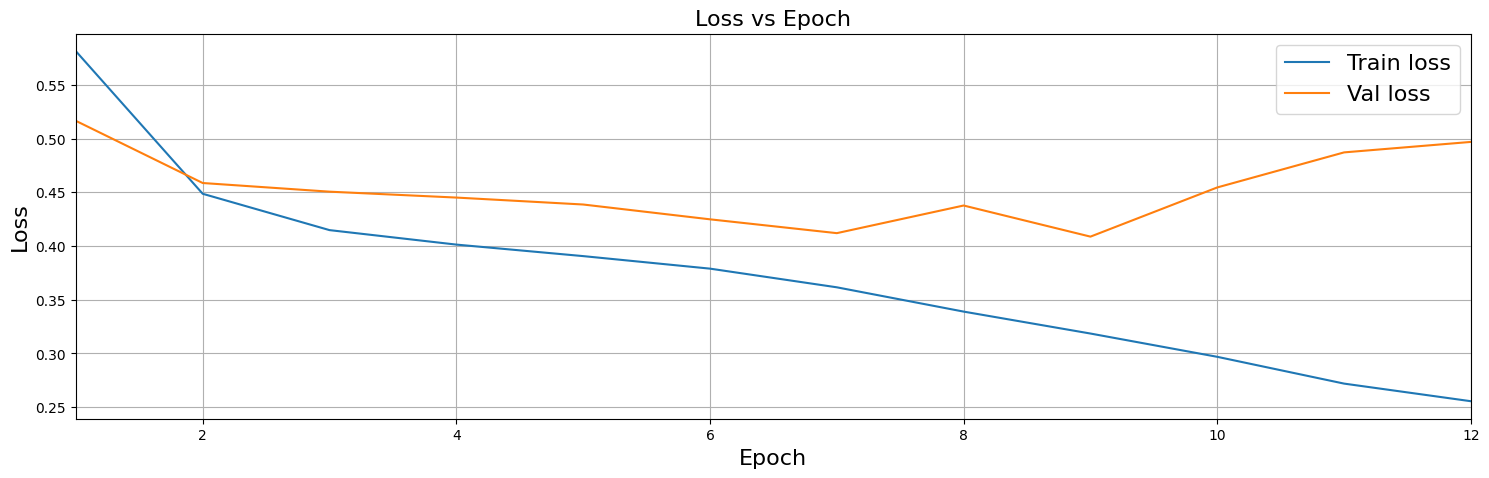

Train loss: 0.2555404924622206, val loss: 0.4969695784262757, num epochs: 12
Best val loss: 0.4087822387245164, at epoch: 9


In [89]:
# Plot validation and training loss vs number of epochs here
if len(train_loss_arr) > len(val_loss_arr): 
    train_loss_arr = train_loss_arr[:-1]
num_epochs = len(train_loss_arr) 
x = range(1, num_epochs + 1)
plt.figure(figsize=(18,5))
plt.plot(x, train_loss_arr)
plt.plot(x, val_loss_arr) 
plt.legend(["Train loss", "Val loss"], fontsize=16)
plt.xlabel("Epoch", fontsize=16)
plt.xlim([1, num_epochs])
plt.ylabel("Loss", fontsize=16)
plt.title("Loss vs Epoch", fontsize=16)  
plt.grid()
plt.show() 

idx = np.argmin(val_loss_arr)
print(f'Train loss: {train_loss_arr[-1]}, val loss: {val_loss_arr[-1]}, num epochs: {num_epochs}')
print(f'Best val loss: {val_loss_arr[idx]}, at epoch: {idx + 1}')


### Testing:


#### Testing model 

In [15]:
# Reimplemnt pose matrix to vector >:(

def pose_vector_from_matrix(pose, seq_length):
    """
    Convert 4x4 pose matrix (as a flattenned length 16 vector) into a position and quaternion length 7 vector.
    """
    pose = pose.reshape(seq_length, 4, 4)
    position = pose[:, :3, 3].reshape(seq_length, 3)
    orientation = pose[:, :3, :3]

    quat = R.from_matrix(orientation).as_quat().reshape(seq_length, 4)
    norm_quat = quat / np.linalg.norm(quat)

    return np.hstack((position, norm_quat))

In [21]:
# Load noisy sequence 
path_to_sequence = '~/cv_project_code/project/data/filter_net/processed_flow/test3/inputs'
sequence_start = 2561 #2561
sequence = torch.zeros((seq_length, 1, 480, 848))

for i in range(seq_length): 
    idx = sequence_start + i 
    img = io.imread(os.path.join(path_to_sequence, f'frame{idx:05d}.png'))
    img = torch.from_numpy((img[..., 0] > 127).astype(np.float32))
    sequence[i] = img 

transform = transforms.Resize((256, 256)) 
sequence = transform(sequence) 
sequence = sequence.unsqueeze(0).float() # Add batch dimension 


# Load pose and twist 
pose = pd.read_csv(os.path.join(path_to_sequence, 'bd_poses.csv')).to_numpy()[sequence_start:sequence_start + seq_length, :]
pose = pose_vector_from_matrix(pose, seq_length)
twist = pd.read_csv(os.path.join(path_to_sequence, 'bd_twists.csv')).to_numpy()[sequence_start:sequence_start + seq_length, :]
state = torch.from_numpy(np.hstack((pose, twist)))
state = state.unsqueeze(0).float() # Add batch dimension 

# Make dummy output 
out_seq = torch.zeros_like(sequence) 

# Build input dict 
datapoint = {'input': (sequence.to(device), state.to(device)), 'target': out_seq.to(device)} 

# Save og image for plotting 
og_image = sequence[0, -1, 0, :, :].detach().numpy().copy()
target = out_seq[0, -1, 0, :, :].detach().numpy().copy()


In [ ]:
# Test model 
# Conv3d model time: 0.006s

import time 
model.eval() 
torch.cuda.synchronize()
start = time.time() 
_, pred_frame = model.loss(datapoint)

torch.cuda.synchronize()
print(f"Took {time.time() - start} seconds to compute")


Took 0.00334930419921875 seconds to compute


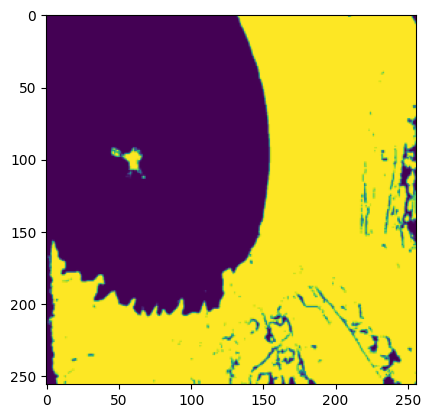

In [72]:
# Plot output frame 
plt.imshow(og_image)

tensor(0.9977, device='cuda:0', grad_fn=<MaxBackward1>)

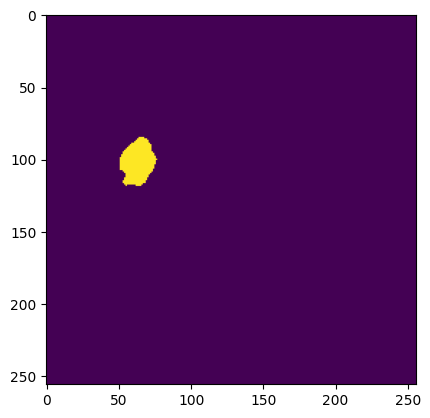

In [73]:
prob_pred_frame = torch.sigmoid(pred_frame)
out = (prob_pred_frame > 0.5).to(torch.float32) 
plt.imshow(out[0, 0, :, :].cpu().detach().numpy())
out.max()
prob_pred_frame.max()

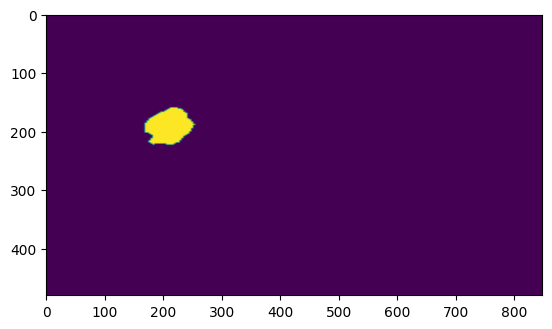

In [74]:
h, w = 480, 848
resize_frame = transforms.Resize((h, w))
output_frame = resize_frame(out[0, 0, :, :].unsqueeze(0))
plt.imshow(output_frame[0, :, :].cpu().detach().numpy())

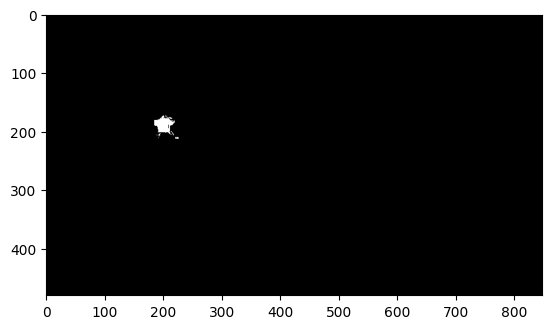

In [75]:
# Actual gt 
path_to_sequence = '~/cv_project_code/project/data/filter_net/processed_flow/test3/targets'
idx = sequence_start + (seq_length - 1)
img = io.imread(os.path.join(path_to_sequence, f'frame{idx:05d}.png'))
plt.imshow(img)

#### Testing dataloader

#### Save model 


In [ ]:
# path_to_save = "/home/jrached/cv_project_code/cv_project/models/filternet1.pt"
# torch.save(model.state_dict(), path_to_save)

### Then to load 
# model = FilterNet() 
# model.load_state_dict(torch.load(path_to_save, weights_only=True))
# model.eval()

#### Misc: Dataloader testing and visualize estimated twist

In [20]:
batch_size = 1
dataset = VideoDataset(path_to_data, augmented=augmented, num_vids=7, seq_length=seq_length, img_size=img_size)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0) #NOTE: num_workers is the number of extra processes running in parallel retrieving the data
counter = 0
for datapoint in loader:
    # found_one = False
    # features = datapoint['input']
    # labels = datapoint['target']
    if counter > 1:
        break
    counter += 1
    # for i in range(batch_size):
    #     image = features[0][i]
    #     if counter > 1502:
    #         found_one = True
    #         break
    #     counter += 1

    # if found_one:
    #     break

# counter
# len(datapoint)
in_frame = datapoint['input'][0][0, -1, 0, :, :]
out_frame = datapoint['target'][0, -1, 0, :, :]
# datapoint['input'][:, 0, :, :, :, 1]
# counter

100%|██████████| 7/7 [00:00<00:00, 169.65it/s]


In [ ]:
# Use transforms to resize images
# This is an example, but it must actually be performed before feeding image data to encoder
# For the augmented tensor the image is already resized inside the dataloader

sequence = next(iter(loader))
if augmented:
    input, target = sequence['input'], sequence['target']
    print(f'Tensor shape should be: [{batch_size, seq_length, 1, img_size, img_size, 14}] and is: {input.shape}')
else:

    features = sequence
    image = features['input'][0]
    input, target = features['input'], features['target']
    print(f'\nBatched image shape should be: [{batch_size, seq_length, 1, img_size, img_size}] and is: {image.shape}')


tensor(1.0000)


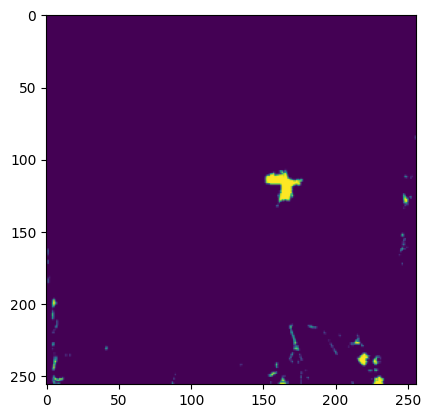

In [ ]:
print(in_frame.max())
plt.imshow(in_frame)

tensor(1.0000)


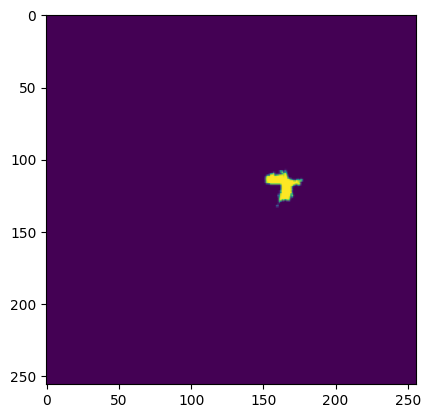

In [ ]:
print(out_frame.max())
plt.imshow(out_frame)

In [ ]:
features[0].shape
counter

1503

In [ ]:
pose = features[1]
pose[28]

tensor([-1.3603,  0.6753,  2.2040,  0.0300,  0.0131,  0.1257,  0.9915])

#### Testing interpolated twist

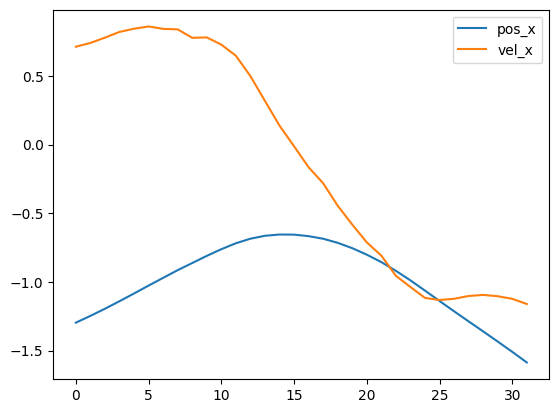

In [ ]:
features[1]
twist = features[2]

plt.plot(pose[:, 0])
plt.plot(twist[:, 0])
plt.legend(["pos_x", "vel_x"])
plt.show()

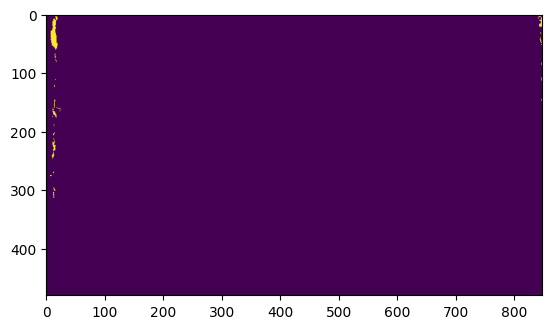

In [ ]:
image = features[0][28]
image.max()
plt.imshow(image)

torch.Size([32, 256, 256])